In [ ]:
from google.colab import drive
drive.mount('/drive')
import pandas as pd
import numpy as np

from collections import Counter
from collections import OrderedDict

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import dill as pickle

import re

Mounted at /drive


[Ноутбук-парсер](https://colab.research.google.com/drive/1TYIdqMCi_LVXlQTXb6NXl5bAaZRFcE3r?usp=sharing)

[Ноутбук с преобразованием после парсинга и формированием итогового датасета](https://colab.research.google.com/drive/1gpbbtj6USRIrekerWTgq73R2GiW-Ep2A?usp=sharing)

[используемый dataset](https://drive.google.com/file/d/1LA0lVpvVLfxVklhas4LPx5ZA9caeZaO3/view?usp=sharing)



#Ввод необработанного dataset(а)

In [ ]:
#это датасет слепленный из того, что спарсил и того, что был на kaggle/ в соледующих ячейках он значительно фильтруется
df_origin = pd.read_csv('/drive/MyDrive/!SberDataScience/Курсовой проект/!main/dataset/final.csv')
#df_origin = pd.read_csv('final.csv')

In [ ]:
#Удаляем строку с аномальной зарплатой до 5000 рублей
df_origin = df_origin[~((df_origin['Employer'] == 'Hoodies') & (df_origin['To'] == 5000))]

In [ ]:
df_origin.nunique()

Ids            56604
Employer       11727
Name           34813
Salary             2
From             654
To               649
Experience         4
Schedule           5
Skills         41472
Description    53694
dtype: int64

#1. Деление на группы, формирование наборов навыков, характерных для каждой из групп
составим список слов, характерных для наименования должностей, присутствующих в датасете (по этим словам осуществлялся парсинг) + их различных модификаций (заглавные/строчные буквы, дефисы)

In [ ]:
df_origin.shape

(60042, 10)

In [ ]:
ds = '(data[-\s]scien.+)|((dl|deep|machine|ml|ai)[-\s](инженер|engineer|researcher|исследователь))'
da = '(data[-\s][anal.+|анали.+])|(анали.+\sданных)'
de = '((big\s?)?data[-\s](инженер|engineer|process))|инженер (больших )?данных'
dev = '((python|big\s?data)[-\s](developer|разработчик|программист))|((developer|разработчик|программист)[-\s]python)'


df_origin[(df_origin.Name.str.contains(dev, case=False))|(df_origin.Name.str.contains(ds, case=False))| \
   (df_origin.Name.str.contains(da, case=False))|(df_origin.Name.str.contains(de, case=False))].shape

(5520, 10)

Сформируем новый датасет из исходного путем поиска в полях Name, Skills, Description

In [ ]:
df = df_origin[(df_origin.Name.str.contains(dev, case=False))|(df_origin.Name.str.contains(ds, case=False))|(df_origin.Name.str.contains(da, case=False))|(df_origin.Name.str.contains(de, case=False))]

In [ ]:
df.drop_duplicates(inplace=True)
df.shape

(4569, 10)

Введем новый столбец "Category" с четырьмя возможными значениями в соответствии с названиями групп вокруг которых строился датасет (DS, DA, DE, Python Develop)

In [ ]:
df['Category'] = np.nan

In [ ]:
df.loc[(df.Name.str.contains(dev, case=False)), 'Category'] = 'Python Develop'
df.loc[(df.Name.str.contains(da, case=False)), 'Category'] = 'Data Analysis'
df.loc[(df.Name.str.contains(de, case=False)), 'Category'] = 'Data Engineer'
df.loc[(df.Name.str.contains(ds, case=False)), 'Category'] = 'Data Science'

In [ ]:
df.head(3)

,Ids,Employer,Name,Salary,From,To,Experience,Schedule,Skills,Description,Category
16,49123325,Клевер Солюшнс,Backend Python Developer (middle/team lead),True,140000.0,200000.0,От 3 до 6 лет,Полный день,"Git,Redis,Django Framework,Базы данных,Python,...",Компания Qlever Solutions занимается разработк...,Python Develop
25,48973744,FunBox,Python-разработчик,True,170000.0,NaN,От 1 года до 3 лет,Полный день,"Python,Django,Django REST Framework,PyTest,Git...",Вам предстоит участвовать в разработке сложных...,Python Develop
50,49516178,Важная рыба,Аналитик данных,True,80000.0,120000.0,От 1 года до 3 лет,Удаленная работа,"Веб-дизайн,Дизайн,Web-дизайн,Немецкий язык,Упр...",Команда Важной Рыбы сейчас активно растет и ищ...,Data Analysis


На основании строк с заполненными навыками сформируем общий массив навыков датасета

In [ ]:
all_skills = []
all_skills_texts = []
for i, row in df.loc[df['Skills'].isna() == False].iterrows():
  all_skills_texts.append(row['Skills'])
  for skill in row['Skills'].split(','):
    all_skills.append(skill)
print(f'Всего собрано навыков: {len(all_skills)} Из них уникальных: {len(set(all_skills))}')

Всего собрано навыков: 24545 Из них уникальных: 1717


Сформируем список кортежей ("название навыка" - "частота в вакансиях датасета")

Для примера вывел первые 20 позиций. 

In [ ]:
counts = Counter(all_skills)
counts.most_common(20)

[('Python', 3181),
 ('SQL', 2190),
 ('PostgreSQL', 948),
 ('Git', 892),
 ('Linux', 739),
 ('Django Framework', 584),
 ('Английский язык', 576),
 ('Анализ данных', 457),
 ('Docker', 388),
 ('ETL', 324),
 ('Spark', 323),
 ('Hadoop', 321),
 ('Big Data', 278),
 ('Базы данных', 261),
 ('Математическая статистика', 255),
 ('Flask', 246),
 ('Data Analysis', 242),
 ('MS SQL', 238),
 ('Аналитическое мышление', 232),
 ('Java', 199)]

In [ ]:
dict(counts.most_common(20))

{'Big Data': 278,
 'Data Analysis': 242,
 'Django Framework': 584,
 'Docker': 388,
 'ETL': 324,
 'Flask': 246,
 'Git': 892,
 'Hadoop': 321,
 'Java': 199,
 'Linux': 739,
 'MS SQL': 238,
 'PostgreSQL': 948,
 'Python': 3181,
 'SQL': 2190,
 'Spark': 323,
 'Анализ данных': 457,
 'Аналитическое мышление': 232,
 'Английский язык': 576,
 'Базы данных': 261,
 'Математическая статистика': 255}

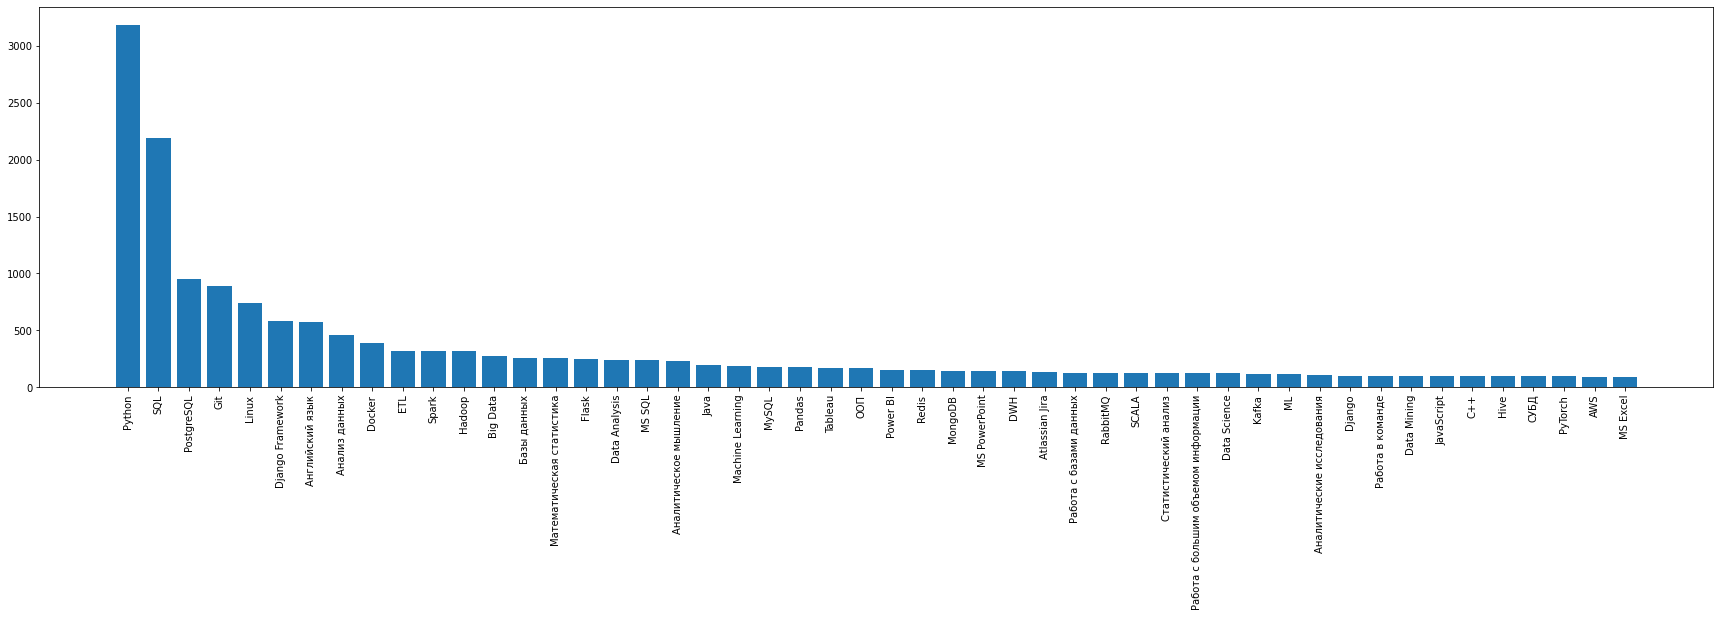

In [ ]:
plt.figure(figsize = (30,7))
plt.bar(list(dict(counts.most_common(50)).keys()), list(dict(counts.most_common(50)).values()))

plt.xticks(rotation = 90);
plt.show()

In [ ]:
counts_most_common = counts.most_common()

Для вакансий с незаполненными полями навыков заполним их следующим образом:
проведем поиск по полю "Description" на наличие слов, совпадающих с нашим набором навыков. Из найденных слов и сформируем поле "Skills" соответствующих вакансий

In [ ]:
current_skill_list = []
for i, row in df.loc[df['Skills'].isna()][['Description', 'Ids']].iterrows():
  for skill in dict(counts_most_common).keys():
    if skill in row.Description:
      current_skill_list.append(skill)
  df.loc[df['Ids'] == row.Ids, 'Skills'] = ','.join(current_skill_list)
  current_skill_list = []

In [ ]:
df[df['Skills'].isna()].shape

(0, 11)

##По вакансиям, уже распределенным на группы составим списки навыков, характерных для каждой группы, далее выделим группы навыков присутствующие только в конкретной группе (отсутствующие в трёх оставшихся)

###Если брать словарь навыков, присутствующих не менее чем в 10 вакансиях датасета (топ 240 навыков)

In [ ]:
counts_most_common_top = counts_most_common[:240].copy()


In [ ]:
counts_most_common_top

[('Python', 3181),
 ('SQL', 2190),
 ('PostgreSQL', 948),
 ('Git', 892),
 ('Linux', 739),
 ('Django Framework', 584),
 ('Английский язык', 576),
 ('Анализ данных', 457),
 ('Docker', 388),
 ('ETL', 324),
 ('Spark', 323),
 ('Hadoop', 321),
 ('Big Data', 278),
 ('Базы данных', 261),
 ('Математическая статистика', 255),
 ('Flask', 246),
 ('Data Analysis', 242),
 ('MS SQL', 238),
 ('Аналитическое мышление', 232),
 ('Java', 199),
 ('Machine Learning', 188),
 ('MySQL', 183),
 ('Pandas', 180),
 ('Tableau', 172),
 ('ООП', 168),
 ('Power BI', 155),
 ('Redis', 149),
 ('MongoDB', 145),
 ('MS PowerPoint', 144),
 ('DWH', 142),
 ('Atlassian Jira', 132),
 ('Работа с базами данных', 130),
 ('RabbitMQ', 129),
 ('SCALA', 128),
 ('Статистический анализ', 125),
 ('Работа с большим объемом информации', 125),
 ('Data Science', 125),
 ('Kafka', 120),
 ('ML', 116),
 ('Аналитические исследования', 112),
 ('Django', 104),
 ('Работа в команде', 104),
 ('Data Mining', 102),
 ('JavaScript', 102),
 ('C++', 100),
 ('H

In [ ]:
top_list_skills = list(dict(counts_most_common_top).keys())

In [ ]:
top_list_skills

['Python',
 'SQL',
 'PostgreSQL',
 'Git',
 'Linux',
 'Django Framework',
 'Английский язык',
 'Анализ данных',
 'Docker',
 'ETL',
 'Spark',
 'Hadoop',
 'Big Data',
 'Базы данных',
 'Математическая статистика',
 'Flask',
 'Data Analysis',
 'MS SQL',
 'Аналитическое мышление',
 'Java',
 'Machine Learning',
 'MySQL',
 'Pandas',
 'Tableau',
 'ООП',
 'Power BI',
 'Redis',
 'MongoDB',
 'MS PowerPoint',
 'DWH',
 'Atlassian Jira',
 'Работа с базами данных',
 'RabbitMQ',
 'SCALA',
 'Статистический анализ',
 'Работа с большим объемом информации',
 'Data Science',
 'Kafka',
 'ML',
 'Аналитические исследования',
 'Django',
 'Работа в команде',
 'Data Mining',
 'JavaScript',
 'C++',
 'Hive',
 'СУБД',
 'PyTorch',
 'AWS',
 'MS Excel',
 'ClickHouse',
 'Kubernetes',
 'Numpy',
 'Аналитика',
 'ORACLE',
 'Bash',
 'Математическое моделирование',
 'Математический анализ',
 'Tensorflow',
 'API',
 'Airflow',
 'NLP',
 'REST',
 'Бизнес-анализ',
 'Celery',
 'Управление проектами',
 'Atlassian Confluence',
 'Маши

Удалим из Skills редкие навыки (менее 1% от выбрки)

In [ ]:
for ids in df.index:
   skill_list = df.at[ids, 'Skills'].split(',')
   new_skill_list = ''
   for i in skill_list:
     if i in top_list_skills:
       if len(new_skill_list) == 0:
         new_skill_list = i
       else:
         new_skill_list = new_skill_list + ',' + i
  
   df.at[ids, 'Skills'] = new_skill_list



In [ ]:
df.loc[df['Skills'] == '', 'Skills'] = np.nan
df.drop(df.loc[df.Skills.isna()].index, inplace = True)

In [ ]:
df[df['Skills'].isna()].shape

(0, 11)

In [ ]:
skill_frequency = dict()
skill_frequency_ids = dict()

for skill in tqdm(dict(counts_most_common_top).keys()):
  count = 0
  Ids_list = []
  for i,row in df[['Skills', 'Ids']].iterrows():
    if skill in row.Skills:
      count += 1
      Ids_list.append(row.Ids)
  skill_frequency_ids[skill] = (count, Ids_list)
  skill_frequency[skill] = count


100%|██████████| 240/240 [01:02<00:00,  3.85it/s]


In [ ]:
#набор навыков для каждой подгруппы датасета
skills_data_science = []
skills_data_analysis = []
skills_python_develop = []
skills_data_engineer = []

for skill in tqdm(dict(counts_most_common_top).keys()):
  for i,row in df[['Skills', 'Category']].iterrows():
    if skill in row.Skills and row.Category == 'Python Develop':
      skills_python_develop.append(skill)
    elif skill in row.Skills and row.Category == 'Data Analysis':
      skills_data_analysis.append(skill)
    elif skill in row.Skills and row.Category == 'Data Science':
      skills_data_science.append(skill)
    elif skill in row.Skills and row.Category == 'Data Engineer':
      skills_data_engineer.append(skill)  




100%|██████████| 240/240 [01:32<00:00,  2.60it/s]


In [ ]:
print(f'Количество навыков характерных для каждой группы датасета:\n'
      f'- для группы data_science: {len(set(skills_data_science))}\n'
      f'- для группы data_analysis: {len(set(skills_data_analysis))}\n'
      f'- для группы data_engineer: {len(set(skills_data_engineer))}\n'
      f'- для группы python develop: {len(set(skills_python_develop))}')

Количество навыков характерных для каждой группы датасета:
- для группы data_science: 185
- для группы data_analysis: 195
- для группы data_engineer: 181
- для группы python develop: 186


In [ ]:
skills_data_science_only = set(skills_data_science).difference(set(skills_data_analysis),set(skills_data_engineer), set(skills_python_develop))
skills_data_analysis_only = set(skills_data_analysis).difference(set(skills_data_science),set(skills_data_engineer), set(skills_python_develop))
skills_data_engineer_only = set(skills_data_engineer).difference(set(skills_data_science),set(skills_data_analysis), set(skills_python_develop))
skills_python_develop_only = set(skills_python_develop).difference(set(skills_data_science),set(skills_data_engineer), set(skills_data_analysis))

print(f'Количество навыков присутствующих только в определенной группе(отсутствующие в оставшихся трёх):\n'
      f'- для группы data_science: {len(skills_data_science_only)}\n'
      f'- для группы data_analysis: {len(skills_data_analysis_only)}\n'
      f'- для группы data_engineer: {len(skills_data_engineer_only)}\n'
      f'- для группы python develop: {len(skills_python_develop_only)}')

Количество навыков присутствующих только в определенной группе(отсутствующие в оставшихся трёх):
- для группы data_science: 1
- для группы data_analysis: 4
- для группы data_engineer: 2
- для группы python develop: 16


In [ ]:
df[df['Category'].isna()].shape

(0, 11)

Если в вакансии, не распределенной на группы, присутствуют навыки из списка, характерного только для этой группы, присваиваем этой вакансии данную группу

In [ ]:
def sorted_ordered_dict(dict):
  sorted_tuples = sorted(dict.items(), key = lambda item: item[1], reverse= True)
  sorted_dict = {k:v for k,v in sorted_tuples}
  return OrderedDict(sorted_dict)

for i,row in df[df['Category'].isna()].iterrows():

  dict_cat = dict()
  dict_cat['Data Science'] = len(set(row.Skills.split(',')).intersection(skills_data_science_only))
  dict_cat['Data Analysis'] = len(set(row.Skills.split(',')).intersection(skills_data_analysis_only))
  dict_cat['Data Engineer'] = len(set(row.Skills.split(',')).intersection(skills_data_engineer_only))
  dict_cat['Python Develop'] = len(set(row.Skills.split(',')).intersection(skills_python_develop_only))
  if list(sorted_ordered_dict(dict_cat).values())[0] != 0:
    df.loc[df['Ids'] == row.Ids, 'Category'] = list(sorted_ordered_dict(dict_cat).keys())[0]

  
print(f"Список вакансий с незаполненными группами после заполнения на основании списков уникальных навыков: {df[df['Category'].isna()].shape[0]}")

Список вакансий с незаполненными группами после заполнения на основании списков уникальных навыков: 0


Остальным вакансиям присваимваем группу на основании максимального совпадения присутствующих в ней навыков с навыками, характерными для группы

In [ ]:
for i,row in df[df['Category'].isna()].iterrows():
  dict_cat = dict()
  dict_cat['Data Science'] = len(set(row.Skills.split(',')).intersection(set(skills_data_science)))
  dict_cat['Data Analysis'] = len(set(row.Skills.split(',')).intersection(set(skills_data_analysis)))
  dict_cat['Data Engineer'] = len(set(row.Skills.split(',')).intersection(set(skills_data_engineer)))
  dict_cat['Python Develop'] = len(set(row.Skills.split(',')).intersection(set(skills_python_develop)))
  if list(sorted_ordered_dict(dict_cat).values())[0] != 0:
    df.loc[df['Ids'] == row.Ids, 'Category'] = list(sorted_ordered_dict(dict_cat).keys())[0]

print(f"Список вакансий с незаполненными группами после заполнения на основании максимального совпадения навыков вакансии-навыков группы: {df[df['Category'].isna()].shape[0]}")

Список вакансий с незаполненными группами после заполнения на основании максимального совпадения навыков вакансии-навыков группы: 0


Вакансии с незаполненными группами удаляем из датасета

In [ ]:
df.drop(df.loc[df.Category.isna()].index, inplace = True)
df[df['Category'].isna()].shape

(0, 11)

#2. Заполнение пропусков в зарплатах


In [ ]:
df.drop(columns=['Ids'], inplace = True)
df.drop_duplicates(inplace=True)
df.shape

(4034, 10)

Посмотрим на наиболее частые слова в названии должностей

In [ ]:
all_words_in_names = []
for i, row in df[['Name']].iterrows():
  for word in row['Name'].split(' '):
    all_words_in_names.append(word)

len(all_words_in_names), len(set(all_words_in_names))

(14776, 2241)

In [ ]:
counts = Counter(all_words_in_names)
counts.most_common(50)

[('Data', 1649),
 ('Python', 1245),
 ('данных', 695),
 ('Аналитик', 586),
 ('Engineer', 547),
 ('Developer', 411),
 ('Scientist', 393),
 ('/', 334),
 ('Senior', 327),
 ('разработчик', 289),
 ('developer', 257),
 ('в', 239),
 ('Analyst', 237),
 ('Разработчик', 208),
 ('Python-разработчик', 183),
 ('engineer', 169),
 ('Middle', 156),
 ('scientist', 130),
 ('Программист', 126),
 ('аналитик', 124),
 ('по', 108),
 ('Junior', 98),
 ('analyst', 93),
 ('Ведущий', 88),
 ('Lead', 85),
 ('и', 79),
 ('ML', 76),
 ('Science', 73),
 ('команду', 70),
 ('(Data', 62),
 ('Middle/Senior', 60),
 ('data', 57),
 ('Big', 56),
 ('данных)', 55),
 ('Team', 48),
 ('(удаленно)', 46),
 ('баз', 45),
 ('(Middle)', 42),
 ('Инженер', 40),
 ('Руководитель', 37),
 ('программист', 36),
 ('инженер', 34),
 ('Backend', 33),
 ('-', 32),
 ('Старший', 32),
 ('(Big', 30),
 ('BI', 28),
 ('python', 28),
 ('Data)', 27),
 ('Системный', 27)]

In [ ]:
print(f'Количество должностей Senior: {df["Name"].str.contains("Senior|senior").sum()}')
print(f'Количество должностей Middle: {df["Name"].str.contains("Middle|middle").sum()}')
print(f'Количество должностей Junior: {df["Name"].str.contains("Junior|junior").sum()}. Ну да, конечно, кому джуны сдались :)')
print(f'Количество должностей Lead: {df["Name"].str.contains("Lead|lead").sum()}')
print(f'Количество должностей со словом руководитель: {df["Name"].str.contains("Руководитель|Руководитель").sum()}')


Количество должностей Senior: 520
Количество должностей Middle: 399
Количество должностей Junior: 131. Ну да, конечно, кому джуны сдались :)
Количество должностей Lead: 128
Количество должностей со словом руководитель: 40


Сформируем столбец Position level  

In [ ]:
df['Position_level'] = 'other'

for name in ['Руководитель', 'Начальник', 'Lead', 'Главный', 'Директор', 'Старший', 'Ведущий', 'Head']:  
  df.loc[df["Name"].str.contains(name, case = False), 'Position_level'] = 'Lead'

df.loc[df["Name"].str.contains('Senior', case = False), 'Position_level'] = 'Senior'
df.loc[df["Name"].str.contains('Middle', case = False), 'Position_level'] = 'Middle'

for name in ['Стажер', 'Ассистент', 'Младший', 'Помощник', 'Junior']:  
  df.loc[df["Name"].str.contains(name, case = False), 'Position_level'] = 'Junior'

df[df['Position_level'].isna()].shape

(0, 11)

In [ ]:
df.loc[(df['Position_level'] == 'other')&(df['Experience'] == 'Нет опыта'), 'Position_level'] = 'Junior'
df.loc[(df['Position_level'] == 'other')&(df['Experience'] == 'От 1 года до 3 лет'), 'Position_level'] = 'Middle'

In [ ]:
df.head(10)

,Employer,Name,Salary,From,To,Experience,Schedule,Skills,Description,Category,Position_level
16,Клевер Солюшнс,Backend Python Developer (middle/team lead),True,140000.0,200000.0,От 3 до 6 лет,Полный день,"Git,Redis,Django Framework,Базы данных,Python,...",Компания Qlever Solutions занимается разработк...,Python Develop,Middle
25,FunBox,Python-разработчик,True,170000.0,NaN,От 1 года до 3 лет,Полный день,"Python,Django,Git,Linux,Работа в команде",Вам предстоит участвовать в разработке сложных...,Python Develop,Middle
144,Spark Equation,Data Scientist (Remote),True,120000.0,190000.0,От 3 до 6 лет,Удаленная работа,"Machine Learning,Python,Java,SQL,Data Mining,D...",Spark Equation is a software-enabled IT and st...,Data Science,other
169,Vilesse,Разработчик Python,True,130500.0,174000.0,От 3 до 6 лет,Удаленная работа,"Python,CSS,JavaScript,React,Docker,Git,HTML5,D...",О нас:Мы - международная софтверная компания с...,Python Develop,other
198,Самокат (ООО Умное пространство),Data engineer,False,NaN,NaN,От 3 до 6 лет,Полный день,"SQL,ETL,Spark,Hadoop,Big Data,Java,Kafka,Hive,...","«Самокат» — технологическая компания, создающа...",Data Engineer,other
246,GetConduit.app,Разработчик Python Middle/Senior - Remote,True,186667.0,NaN,От 3 до 6 лет,Удаленная работа,"Django Framework,Python,Git,PostgreSQL",Мы делаем аналитический продукт для e-commerce...,Python Develop,Middle
325,"Петрович, Строительный Торговый Дом",Data Engineer (удаленно),False,NaN,NaN,От 1 года до 3 лет,Удаленная работа,"Python,SQL",Кто мы? Строительный Торговый Дом «Петрович» -...,Data Engineer,Middle
352,Selectel,Data Engineer в команду BI,False,NaN,NaN,От 1 года до 3 лет,Гибкий график,"SQL,Python,ETL,Qlik Sense,Docker,Linux,Airflow",Команда BI в Selectel входит в состав Департам...,Data Engineer,Middle
467,Лаборатория Корпоративного Сопровождения,Python разработчик,False,NaN,NaN,От 3 до 6 лет,Гибкий график,"Python,Flask,MongoDB,Docker,PostgreSQL,SQLAlch...",Лаборатория корпоративного сопровождения - это...,Python Develop,other
584,Сбербанк,Python-разработчик в Цифровые поверхности Салю...,False,NaN,NaN,От 1 года до 3 лет,Полный день,"Python,Django Framework,PostgreSQL,Unit Testing",SberDevices — уникальное IT-пространство внутр...,Python Develop,Middle


In [ ]:
print(f"Количество вакансий c зарплатой заполненной от и до: {df[(df['From'].isna()==False) & (df['To'].isna()==False)].shape[0]}\n"
      f"Количество вакансий c заполненной зарплатой до: {df[(df['From'].isna()==False) & (df['To'].isna()==True)].shape[0]}\n"
      f"Количество вакансий c заполненной зарплатой от: {df[(df['From'].isna()==True) & (df['To'].isna()==False)].shape[0]}\n")

Количество вакансий c зарплатой заполненной от и до: 456
Количество вакансий c заполненной зарплатой до: 353
Количество вакансий c заполненной зарплатой от: 156



Сгруппируем вакансии по категории, позиции и отразим для них среднее значение разности между значениями "От" и "До"

In [ ]:
df_salary_difference_median = \
          df[(df['From'].isna()==False) & (df['To'].isna()==False)].groupby(['Category','Position_level']).median()['To'] -\
          df[(df['From'].isna()==False) & (df['To'].isna()==False)].groupby(['Category','Position_level']).median()['From']
df_salary_difference_median

Category        Position_level
Data Analysis   Junior             40000.0
                Lead               34800.0
                Middle             60000.0
                Senior            110000.0
                other              70000.0
Data Engineer   Junior             72883.0
                Middle             97500.0
                Senior            135250.0
                other             170000.0
Data Science    Junior             48690.0
                Lead              182700.0
                Middle             90000.0
                Senior            137400.5
                other             100800.0
Python Develop  Junior             50000.0
                Lead              120000.0
                Middle             80000.0
                Senior            105000.0
                other              70000.0
dtype: float64

In [ ]:
for ind, (category, position) in enumerate(df_salary_difference_median.index):
  print(category, position, df_salary_difference_median[ind])

Data Analysis Junior 40000.0
Data Analysis Lead 34800.0
Data Analysis Middle 60000.0
Data Analysis Senior 110000.0
Data Analysis other 70000.0
Data Engineer Junior 72883.0
Data Engineer Middle 97500.0
Data Engineer Senior 135250.0
Data Engineer other 170000.0
Data Science Junior 48690.0
Data Science Lead 182700.0
Data Science Middle 90000.0
Data Science Senior 137400.5
Data Science other 100800.0
Python Develop Junior 50000.0
Python Develop Lead 120000.0
Python Develop Middle 80000.0
Python Develop Senior 105000.0
Python Develop other 70000.0


Заполним на основании полученых данных поля From или To при условии того, что второе поле заполнено

In [ ]:
for ind, (category, position) in enumerate(df_salary_difference_median.index):
  df.loc[(df['Category'] == category) & (df['Position_level'] == position) & (df['From'].isna()) & (df['To'].isna() == False), 'From'] = df['To'] - round(df_salary_difference_median[ind]/2)
  df.loc[(df['Category'] == category) & (df['Position_level'] == position) & (df['From'].isna() == False) & (df['To'].isna()), 'To'] = df['From'] + round(df_salary_difference_median[ind]/2)  

In [ ]:
print(f"Количество вакансий c зарплатой заполненной от и до: {df[(df['From'].isna()==False) & (df['To'].isna()==False)].shape[0]}\n")

Количество вакансий c зарплатой заполненной от и до: 965



In [ ]:
df.head(10)

,Employer,Name,Salary,From,To,Experience,Schedule,Skills,Description,Category,Position_level
16,Клевер Солюшнс,Backend Python Developer (middle/team lead),True,140000.0,200000.0,От 3 до 6 лет,Полный день,"Git,Redis,Django Framework,Базы данных,Python,...",Компания Qlever Solutions занимается разработк...,Python Develop,Middle
25,FunBox,Python-разработчик,True,170000.0,210000.0,От 1 года до 3 лет,Полный день,"Python,Django,Git,Linux,Работа в команде",Вам предстоит участвовать в разработке сложных...,Python Develop,Middle
144,Spark Equation,Data Scientist (Remote),True,120000.0,190000.0,От 3 до 6 лет,Удаленная работа,"Machine Learning,Python,Java,SQL,Data Mining,D...",Spark Equation is a software-enabled IT and st...,Data Science,other
169,Vilesse,Разработчик Python,True,130500.0,174000.0,От 3 до 6 лет,Удаленная работа,"Python,CSS,JavaScript,React,Docker,Git,HTML5,D...",О нас:Мы - международная софтверная компания с...,Python Develop,other
198,Самокат (ООО Умное пространство),Data engineer,False,NaN,NaN,От 3 до 6 лет,Полный день,"SQL,ETL,Spark,Hadoop,Big Data,Java,Kafka,Hive,...","«Самокат» — технологическая компания, создающа...",Data Engineer,other
246,GetConduit.app,Разработчик Python Middle/Senior - Remote,True,186667.0,226667.0,От 3 до 6 лет,Удаленная работа,"Django Framework,Python,Git,PostgreSQL",Мы делаем аналитический продукт для e-commerce...,Python Develop,Middle
325,"Петрович, Строительный Торговый Дом",Data Engineer (удаленно),False,NaN,NaN,От 1 года до 3 лет,Удаленная работа,"Python,SQL",Кто мы? Строительный Торговый Дом «Петрович» -...,Data Engineer,Middle
352,Selectel,Data Engineer в команду BI,False,NaN,NaN,От 1 года до 3 лет,Гибкий график,"SQL,Python,ETL,Qlik Sense,Docker,Linux,Airflow",Команда BI в Selectel входит в состав Департам...,Data Engineer,Middle
467,Лаборатория Корпоративного Сопровождения,Python разработчик,False,NaN,NaN,От 3 до 6 лет,Гибкий график,"Python,Flask,MongoDB,Docker,PostgreSQL,SQLAlch...",Лаборатория корпоративного сопровождения - это...,Python Develop,other
584,Сбербанк,Python-разработчик в Цифровые поверхности Салю...,False,NaN,NaN,От 1 года до 3 лет,Полный день,"Python,Django Framework,PostgreSQL,Unit Testing",SberDevices — уникальное IT-пространство внутр...,Python Develop,Middle


In [ ]:
#создаем датасет из вакансий с указанными зарплатами
df_real = df[(df.Salary)].copy()


In [ ]:
#убираем аномально низкие "от" в зарплате
df_real.From[df_real['From'] < 30000] = df_real.To

Заполним остальные пробелы в зарплатах на основании средних значений для группы и уровня позиции. Введем новый столбец - средняя з/п

In [ ]:
df_salary_median = \
        (df[(df['From'].isna()==False) & (df['To'].isna()==False)].groupby(['Category','Position_level']).median()['To'] +\
        df[(df['From'].isna()==False) & (df['To'].isna()==False)].groupby(['Category','Position_level']).median()['From'])/2
df_salary_median

Category        Position_level
Data Analysis   Junior             74000.00
                Lead              156600.00
                Middle            110000.00
                Senior            221250.00
                other             196000.00
Data Engineer   Junior            122883.00
                Middle            196250.00
                Senior            333812.50
                other             250000.00
Data Science    Junior             62500.00
                Lead              345675.00
                Middle            192500.00
                Senior            329009.00
                other             262000.50
Python Develop  Junior             70000.00
                Lead              281250.00
                Middle            165000.00
                Senior            295000.25
                other             183750.00
dtype: float64

In [ ]:
df_real['Salary_median'] = (df_real['From']+df_real['To'])/2
df['Salary_median'] = (df['From']+df['To'])/2
for ind, (category, position) in enumerate(df_salary_median.index):
  df.loc[(df['Category'] == category) & (df['Position_level'] == position) & (df['Salary_median'].isna()), 'Salary_median'] = round(df_salary_median[ind])
  df.loc[(df['Category'] == category) & (df['Position_level'] == position) & (df['From'].isna()) & (df['To'].isna()), 'From'] = round(df_salary_median[ind]) - round(df_salary_difference_median[ind]/2)
  df.loc[(df['Category'] == category) & (df['Position_level'] == position) & (df['From'].isna() == False) & (df['To'].isna()), 'To'] = round(df_salary_median[ind]) + round(df_salary_difference_median[ind]/2)
df['Salary'] = True  

In [ ]:
print(f"Количество вакансий c зарплатой заполненной от и до: {df[(df['From'].isna()==False) & (df['To'].isna()==False)].shape[0]}\n"
      f"Количество вакансий c заполненной зарплатой до и НЕзаполненной от: {df[(df['From'].isna()==False) & (df['To'].isna()==True)].shape[0]}\n"
      f"Количество вакансий c заполненной зарпалатой от и НЕзаполненной до: {df[(df['From'].isna()==True) & (df['To'].isna()==False)].shape[0]}\n"
      f"Количество вакансий c НЕзаполненной зарпалатой от и до: {df[(df['From'].isna()) & (df['To'].isna())].shape[0]}. Удалим эти строки\n")

Количество вакансий c зарплатой заполненной от и до: 4010
Количество вакансий c заполненной зарплатой до и НЕзаполненной от: 0
Количество вакансий c заполненной зарпалатой от и НЕзаполненной до: 0
Количество вакансий c НЕзаполненной зарпалатой от и до: 24. Удалим эти строки



In [ ]:
df.dropna(inplace = True)

In [ ]:
print(f"Количество вакансий c зарплатой заполненной от и до: {df[(df['From'].isna()==False) & (df['To'].isna()==False)].shape[0]}\n"
      f"Количество вакансий c заполненной зарплатой до и НЕзаполненной от: {df[(df['From'].isna()==False) & (df['To'].isna()==True)].shape[0]}\n"
      f"Количество вакансий c заполненной зарпалатой от и НЕзаполненной до: {df[(df['From'].isna()==True) & (df['To'].isna()==False)].shape[0]}\n"
      f"Количество вакансий c НЕзаполненной зарпалатой от и до: {df[(df['From'].isna()) & (df['To'].isna())].shape[0]}")

Количество вакансий c зарплатой заполненной от и до: 4010
Количество вакансий c заполненной зарплатой до и НЕзаполненной от: 0
Количество вакансий c заполненной зарпалатой от и НЕзаполненной до: 0
Количество вакансий c НЕзаполненной зарпалатой от и до: 0


Сохранение полученных dataset
 

In [ ]:
df.shape

(4010, 12)

In [ ]:
df_real.shape

(965, 12)

In [ ]:
df.to_csv('/drive/MyDrive/!SberDataScience/Курсовой проект/!main/dataset/final_after_fill_na_salary_median.csv', index=False)
df_real.to_csv('/drive/MyDrive/!SberDataScience/Курсовой проект/!main/dataset/final_without_fill_na_salary.csv', index=False)